# LAPW project

This project is adapted from Thijssen and uses data taken from Energy Band Structure of Copper by Glenn A. Burdick.

This is currently broken.

In [155]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt
from scipy.linalg import eigh


In [156]:
#constants
a = 6.83087
vol = 3*(a**3)/4

#simulation parameters
l_max = 9
nLim = 2

#recipricol lattice vectors 
b1 = 2*np.pi*np.array([-1,1,1])/a
b2 = 2*np.pi*np.array([1,-1,1])/a
b3 = 2*np.pi*np.array([1,1,-1])/a
Ks =[l*b1 + m*b2 + n*b3 for l in range(-nLim,nLim+1) for m in range(-nLim,nLim+1) for n in range(-nLim,nLim+1)]



In [215]:
h = 0.0005
rs = np.arange(0,1,step=h)
r_max = rs[-2]

def V(r):
    term1 = 29.*np.exp(-2.3151241717834*(r**0.81266614122432) + (2.1984250222603E-2)*(r**4.2246376280056))
    term2 = -0.15595606773483*r - (3.1350051440417E-3)*r**2 + (5.1895222293006E-2)*r**3 - (2.8027608685637E-2)*r**4
    return term1 + term2

def simpsons(fs):
    sum1 = fs[0] + fs[-2]
    fsNoEnds = fs[1:-2]
    sum2 = 4*np.sum(fsNoEnds[::2])
    sum3 = 2*np.sum(fsNoEnds[1::2])
    return h*(sum1 + sum2 + sum3)/3

Es = [0.2,0.2,0.2,0.25,0.3,0.4,0.5,0.6,0.7] #explain where these come from, are these required to get good results

#empty global variables
RMax = np.empty(l_max)
RDashMax = np.empty(l_max)
RDotMax = np.empty(l_max)
RDotDashMax = np.empty(l_max)
N = np.empty(l_max)

In [216]:

def getAllUs(l,E):
    def g(r):
        if r == 0:
            return 0
        return l*(l+1)/r**2 + 2*(V(r) - E)
    
    us = np.empty(len(rs))
    us[0] = 0
    us[1] = 10
    
    for n in range(1,len(rs)-1):
        D = 2*us[n]*(1 + 5*(h**2)*g(rs[n])/12) - us[n-1]*(1 - (h**2)*g(rs[n-1])/12)
        N = 1 - (h**2)*g(rs[n+1])/12
        us[n+1] = D/N

    return us/np.sqrt(simpsons(us**2))



In [278]:
def getuDots(l,usR):
    def g(r):
        if r == 0:
            return 0
        return l*(l+1)/r**2 + 2*(V(r) - Es[l])
    
    def s(r):
        index = list(rs).index(r)
        return -2*usR[index]


    usPar = np.empty(len(rs))
    usPar[0] = 0
    usPar[1] = 0 
    
    for n in range(1,len(rs)-1):
        D = (2*usPar[n]*(1 + 5*(h**2)*g(rs[n])/12) - usPar[n-1]*(1 - (h**2)*g(rs[n-1])/12) + (h**2)*(s(rs[n-1]) + 10*s(rs[n]) + s(rs[n+1]))/12)
        N = (1 - (h**2)*g(rs[n+1])/12)
        usPar[n+1] = D/N

    #orthogonalise
    homoConstant = -simpsons(usPar*usR)/simpsons(usR**2)

    return homoConstant*usR + usPar

def test(l,uDots,us):
    print("----")
    for n in range(1,len(rs)-1):
        print("-")
        print(((l*(l+1)/(2*rs[n]**2) + V(rs[n]) - Es[l])*uDots[n] - (uDots[n+1] + uDots[n-1] - 2*uDots[n])/(2*h**2)) - us[n])
        print(((l*(l+1)/(2*rs[n]**2) + V(rs[n]) - Es[l])*uDots[n] - (uDots[n+1] + uDots[n-1] - 2*uDots[n])/(2*h**2)))
        print(us[n])


In [279]:
#find global variables
for l in range(l_max):
    us = getAllUs(l,Es[l]) #remove 2*
    RMax[l] = us[-2]/r_max
    RDashMax[l] = (us[-1] - us[-3])/(2*h*r_max) - us[-2]/(r_max**2)
    uDots = getuDots(l,us)
    #num = (getAllUs(l,Es[l]+0.000005) - getAllUs(l,Es[l]-0.000005))/(2*0.00001)
    RDotMax[l] = uDots[-2]/r_max
    RDotDashMax[l] = (uDots[-1] - uDots[-3])/(2*h*r_max) - uDots[-2]/(r_max**2)

    
    #print((r_max**2)*(RDashMax[l]*RDotMax[l] - RMax[l]*RDotDashMax[l])) 
    #print(simpsons(uDots*us))
    #if l == 1:
    #    test(l,uDots,us)

    N[l] = simpsons(uDots**2)

2.0000018914661433
2.0000025315078944
2.000003726832079
2.000005422983472
2.000007631054786
2.000010322828844
2.000013519106224
2.00001721868671
2.0000214208562594


In [246]:
def getE(k): 
    #define functions required to calcuate matricies
    def a(l,q):
        qMag = np.linalg.norm(q)
        return sp.spherical_jn(l,r_max*qMag,derivative=True)*qMag*RDotMax[l] - sp.spherical_jn(l,r_max*qMag)*RDotDashMax[l]
        
    def b(l,q):
        qMag = np.linalg.norm(q) 
        return sp.spherical_jn(l,r_max*qMag)*RDashMax[l] - sp.spherical_jn(l,r_max*qMag,derivative=True)*qMag*RMax[l]

    def U(K):
        KMag = np.linalg.norm(K)
        if KMag == 0:
            return 1 - 4*np.pi*(r_max**3)/(3*vol)
        return -4*np.pi*(r_max**2)*sp.spherical_jn(1,KMag*r_max)/(KMag*vol)

    def s(q1,q2,l):
        return a(l,q1)*a(l,q2) + b(l,q1)*b(l,q2)*N[l]
    
    def gamma(q1,q2,l):
        q1Mag = np.linalg.norm(q1)
        q2Mag = np.linalg.norm(q2)

        term1 = RDashMax[l]*RDotMax[l]*(sp.spherical_jn(l,r_max*q1Mag,derivative=True)*q1Mag*sp.spherical_jn(l,r_max*q2Mag) + sp.spherical_jn(l,r_max*q2Mag,derivative=True)*q2Mag*sp.spherical_jn(l,r_max*q1Mag))
        term2 = RDashMax[l]*RDotDashMax[l]*sp.spherical_jn(l,r_max*q1Mag)*sp.spherical_jn(l,r_max*q2Mag)
        term3 = RMax[l]*RDotMax[l]*q1Mag*q2Mag*sp.spherical_jn(l,r_max*q1Mag,derivative=True)*sp.spherical_jn(l,r_max*q2Mag,derivative=True)

        return term1 - term2 - term3 #0.5*(a(l,q1)*b(l,q2) + a(l,q2)*b(l,q1))


    #calculate matricies
    qs = [k + K for K in Ks]

    #find overlap matrix
    S = np.empty([len(Ks),len(Ks)])

    for i in range(len(qs)):
        for j in range(i+1):
            cosThetaij = np.dot(qs[i],qs[j])/(np.linalg.norm(qs[i])*np.linalg.norm(qs[j]))
            S[i,j] = U(qs[i] - qs[j])
            for l in range(l_max):
                S[i,j] += 4*np.pi*(r_max**4)*(2*l + 1)*sp.eval_legendre(l,cosThetaij)*s(qs[i],qs[j],l)/vol
            S[j,i] = S[i,j]

    #find Hamiltonian
    H = np.empty([len(Ks),len(Ks)])

    for i in range(len(qs)):
        for j in range(i+1):
            H[i,j] = np.dot(qs[i],qs[j])*U(qs[i] - qs[j]) #0.5*(np.linalg.norm(qs[i]) + np.linalg.norm(qs[j]))*U(qs[i] - qs[j])
            for l in range(l_max):
                H[i,j] += 4*np.pi*(r_max**4)*(2*l + 1)*sp.eval_legendre(l,2*Es[l]*s(qs[i],qs[j],l) + gamma(qs[i],qs[j],l))/vol
            H[j,i] = H[i,j]
    
    eigenVal,eigenVec = eigh(H,S)
    return eigenVal

#print(getE(2*np.pi*np.array([1/10,0,0])/a)[0]) #0.026866118620383194


In [264]:
#finds the energies for a list of k's
ks2 = [2*np.pi*np.array([i/10,0,0])/a for i in range(1,11)]
Es2 = np.empty([len(ks2),20])

for i,k in enumerate(ks2):
    sol = getE(k)
    for j in range(20):
        Es2[i,j] = sol[j]


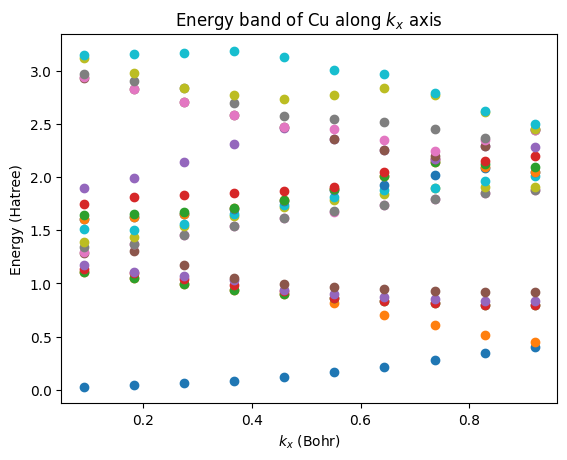

In [265]:
#Graphs 
kx = list(map(lambda k: k[0],ks2))

for i in range(20):
    plt.scatter(kx,Es2[:,i]/2)
plt.title(r"Energy band of Cu along $k_x$ axis")
plt.xlabel(r"$k_x$ (Bohr)")
plt.ylabel("Energy (Hatree)")
plt.show()